In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [4]:
import numpy as np
import pandas as pd
from plotnine import *
from pulp import COIN_CMD
from wurlitzer import sys_pipes

from UCP.data import UCPData
import UCP.model as original_model
import UCP.output.check_solution as ck
from generic.optimization.dual.algorithms.cutting_plane import *
from generic.optimization.dual.algorithms.subgradient import *
from generic.optimization.dual.combined_algorithm import (
    AlgorithmConfiguration,
    BoundsTracker,
    CombinedAlgorithm,
    KpiCollector,
)
from generic.optimization.dual.combined_algorithm import charts as algo_charts
from generic.optimization.dual.combined_algorithm import extract_kpis, pretty_printer
from generic.optimization.solution_extraction import extract_solution
from generic.series_dict import series_dict_to_array
from UCP.output import charts
from UCP.relaxations.combinatorial_heuristic import combinatorial_heuristic
from UCP.relaxations.local_search_heuristic import local_search
from UCP.relaxations.lagrangian.production_state.relaxation import (
    ProductionStateRelaxation,
)

In [5]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [6]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

## Full optimization with Solver

In [7]:
ucp = original_model.create_model(data)
ucp.model.solve(solver=COIN_CMD(mip=1, options=["node depth seconds 180"]))

optimal_cost = optimal_value = ucp.model.objective.value()

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - cbc /tmp/8676a56ae946448f9adf5a537a1e2d41-pulp.mps node depth seconds 180 branch printingOptions all solution /tmp/8676a56ae946448f9adf5a537a1e2d41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1909 COLUMNS
At line 8936 RHS
At line 10841 BOUNDS
At line 11562 ENDATA
Problem MODEL has 1904 rows, 1008 columns and 5058 elements
Coin0008I MODEL read with 0 errors
Option for nodeStrategy changed from fewest to depth
seconds was changed from 1e+100 to 180
Continuous objective value is 137103 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 264 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 147 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 40 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 38 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 36 strengthened rows, 0 s

In [8]:
print(f"Cost: {optimal_cost:15.5g}")

Cost:      1.3923e+05


$\newcommand{\var}[1]{{\color{blue}{#1}}}$
$\newcommand{\mult}[1]{{\color{red}{#1}}}$
$\newcommand{\EIE}{{\textrm{EIE}}}$
$\newcommand{\ENP}{{\textrm{ENP}}}$

# UCP with Lagrangian Decomposition

The original UCP problem is formulated as

$$
  \begin{align}
  \min & \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{it}} + c_{i} \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t} \notag \\
  \text{s.t.} ~~ & \underline{p}_i \var{s_{it}} \le \var{p_{it}} \le \bar{p}_i \var{s_{it}} & \forall i\in I, t\in T\\
       & \var{u^+_{it}} \ge \var{s_{it}} - \var{s_{i(t-1)}} & \forall i\in I, t\in T : t > 0\\
       & \var{u^-_{it}} \ge \var{s_{i(t-1)}} - \var{s_{it}} & \forall i\in I, t\in T : t > 0\\
       & \var{s_{it}} \ge \sum_{t'\in \max(0, t-\tau^+_i) \ldots t} \var{u^+_{it'}} & \forall i\in I, t\in T\\
       & \var{s_{it}} \le 1 - \sum_{t'\in \max(0, t-\tau^-_i) \ldots t} \var{u^-_{it'}} & \forall i\in I, t\in T \label{cons:orig-min-down}\\
       & \sum_{i\in I} \var{p_{it}} + \var{\ENP_{t}} = D_t + \var{\EIE_t} & \forall t\in T \\
       & \var{s_{it}}, \var{u^-_{it}}, \var{u^+_{it}} \in \{0, 1\}  & \forall i\in I, t\in T \label{cons:orig-bin-vars}\\
       & \var{p_{it}}, \var{\EIE_{t}}, \var{\ENP_{t}} \in \mathbb{R}^+_0 & \forall i\in I, t\in T
\end{align}
$$

### Relaxation
We then relax the minimum and maximum production constraints (1), separating the state/integer variables $s_{it}$ from the production/continuous variables $p_{it}$.

The relaxed constraints are re-introduced as penalties in the objective function weighted by lagrangian multipliers, $\lambda^+$ and $\lambda^-$ for the upper and lower bounds resp., yielding the lagrangian function
$$ \begin{align*}
\mathcal{L}(\mult{\mathbf{\lambda}}, \mathbf{\var{x}}) = & \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{it}} + c_{i} \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t} + \mult{\lambda^+_{it}} (\var{p_{it}} - \bar{p}_{i} \var{s_{it}}) + \mult{\lambda^-_{it}} (\underline{p}_{i} \var{s_{it}} - \var{p_{it}}) \\
= & \sum_{i\in I, t\in T} \left ( (l_{i} + (\mult{\lambda^+_{it}} - \mult{\lambda^-_{it}})) \var{p_{it}} + (c_{i} - (\mult{\lambda^+_{it}} - \mult{\lambda^-_{it}})) \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t}
\end{align*}$$

The original variables are called "primal" as the primal is the original problem.

### Decomposition
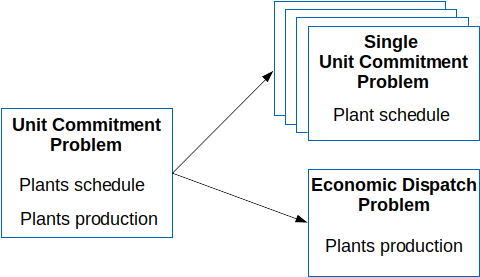

The relaxed problem decomposes into smaller, simpler problems, some of which are independent and thus can be solved in parallel.

* $|I|$ independent single UCP subproblems,  one for each power plant $i$, which compute the minimum cost schedules.<br>
   **Note:** the single UCPs can be reduced to a shortest path problem and can thus be solved directly with e.g. `networkx` methods.
  
  **Single UCP for plant $i$**
$$\begin{align*}
  \min & \sum_{t\in T} (c_{i} - \mult{\lambda^+_{it}} + \mult{\lambda^-_{it}}) \var{s_{it}} \notag \\
  \text{s.t.} ~~ & \var{u^+_{it}} \ge \var{s_{it}} - \var{s_{i(t-1)}} & \forall t\in T : t > 0\\
       & \var{u^-_{it}} \ge \var{s_{i(t-1)}} - \var{s_{it}} & \forall t\in T : t > 0\\
       & \var{s_{it}} \ge \sum_{t'\in \max(0, t-\tau^+_i) \ldots t} \var{u^+_{it'}} & \forall t\in T\\
       & \var{s_{it}} \le 1 - \sum_{t'\in \max(0, t-\tau^-_i) \ldots t} \var{u^-_{it'}} & \forall t\in T \label{cons:orig-min-down}\\
       & \var{s_{it}}, \var{u^-_{it}}, \var{u^+_{it}} \in \{0, 1\}  & \forall t\in T \label{cons:orig-bin-vars}
\end{align*}
$$

* one continuous "economic dispatch" problem that computes the optimal production level of power plants to satisfy demand

  **Economic Dispatch**
$$  \begin{align*}
  \min & \sum_{i\in I, t\in T}  (l_{i} + \mult{\lambda^+_{it}} - \mult{\lambda^-_{it}}) \var{p_{it}} + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t}\notag \\
  \text{s.t.} ~~ & \sum_{i\in I} \var{p_{it}} + \var{\ENP_{t}} = D_t + \var{\EIE_t} & \forall t\in T \\
  & \var{p_{it}}, \var{\EIE_{t}}, \var{\ENP_{t}} \in \mathbb{R}^+_0 & \forall i\in I, t\in T
\end{align*}$$

# Optimization with Lagrangian Decomposition

The structure of the algorithm is given in the picture:

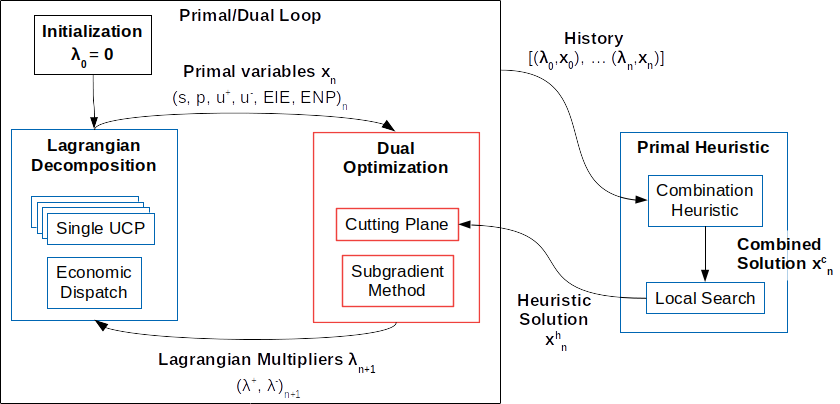

The main components are
* A primal/dual loop  with two steps:
  * Lagrangian decomposition: given current multipliers $\lambda$ computes new primal solutions $x$ by solving the lagrangian subproblems
  * Dual Optimization: given current primal solution $x$ computes new multipliers $\lambda$, using either the Cutting Plane or the Subgradient method
* A primal heuristic that given the "history" of the primal/dual loop, i.e. the list of primal/dual solutions computed so far, computes a new primal solution $x$, hopefully feasible for the original problem, using 
   * combination: choose for each power plant a schedule among the ones in the history to compute a feasible minimum-cost solution.
   * local search: perform limited changes on the combined solution to further reduce its cost.<br>
     The location and radius of the search depends on the "energy prices", computed cheaply via MILP solvers.
  both steps use MILP models. The new heuristic solution can provide additional information to the Cutting Plane model as well.


## Rationale
The "main idea" of the algorithm is to use:
* the primal/dual loop to explore the primal (variables $x$) or dual (variables $\lambda$) space of the problem P to obtain good values for the primal variables $x$ and bounds (estimates) for P's optimal value .
* the primal heuristic to exploit the exploration above and compute a primal solution that is optimal and feasible, i.e. satisfying all the constraints, in particular (1) relaxed by the lagrangian decomposition. <br>
  If lucky, one can generate a good and feasible prmal solution $x$ in the dual loop as well, just by solving the lagrangian decomposition with some lucky multipliers $\lambda$; however this is not considered likely in general, nor the goal of the primal/dual loop.
  
## Algorithm

1. Initialization. $n=0$; set multipliers to a value. For simpicity here we set $\lambda_0=0$ but better methods are usually considered.
2. Step: performa a P/D loop:  
   1. compute new primal variables $x_n$ given $\lambda_n$ by solving the lagrangian decomposition
   2. compute new multipliers $\lambda_{n+1}$ using dual optimization
3. Run the primal heuristic, possibly only every $m$ steps, yielding a new primal solution.
4. If iteration limit is reached ($n = \bar{n}$) or optimality gap is below threshold (see below) stop.<br>
   Otherwise $n := n+1$ and go to #2

## Bounds and optimality gap



At each step $n$, we consider the following (global) bounds:

* dual $B^D_n$: the best known value of the lagrangian dual $\max_{n'\in 1\ldots n} \mathcal{L}(\mult{\lambda_{n'}}, \var{x_{n'}})= \sum_{i\in I, t\in T} \left ( (l_{i} + (\mult{\lambda^+_{itn'}} - \mult{\lambda^-_{itn'}})) \var{p_{itn'}} + (c_{i} - (\mult{\lambda^+_{itn'}} - \mult{\lambda^-_{itn'}})) \var{s_{itn'}} \right ) + \sum_{t\in T} c_{EIE} {\var{EIE_{tn'}}} + \sum_{t\in T} c_{ENP} \var{ENP_{tn'}}$ 
* primal $B^P_n$: the best known value of the primal solutions *that are feasible*: $\min_{n'\in 1\ldots n} \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{itn'}} + c_{i} \var{s_{itn'}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_{tn'}} + \sum_{t\in T} c_{ENP} \var{ENP_{tn'}} $, if $ \underline{p}_i {\var{s_{itn'}}} \le \var{p_{itn'}} \le \bar{p}_i \var{s_{itn'}}$

We have that the optimal value of the original problem $\textrm{opt}(P)$ is between these two bounds:
$$B^D_n \le \textrm{opt}(P) \le B^P_n$$

As the number of iterations grow, the global bounds get closer and closer. <br>
For convex problems the three bounds converge to the same value: the optimal value of P $\textrm{opt}(P)$.<br>
For mixed-integer/non-convex problems the dual converges to a lower (for min problems) value than the optimal value of the original problem P.


The optimality gap is the percentage difference between $B^D_n$ and $B^P_n$ 
$$\mathrm{gap}_n = 100 \frac{B^P_n - B^D_n}{B^P_n}$$
It estimates the potential improvement for the current best primal solution.

Then, an often used stopped criterion for the PDL is when the gap is below a certain threshold $\epsilon$, i.e. when the current solution's potential improvement becomes negligible. Usually $1\% \le \epsilon \le 5\%$

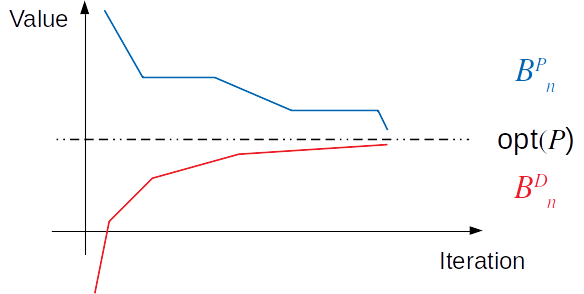

## Dual Optimization

We use two methods:
* Cutting Plane (CP), based on a piece-wise linear model of the lagrangian dual function $\mathcal{D}$. <br>
  For a MILP $\mathcal{D}$ is indeed piece-wise linear, but with an exponential number of breakpoints.
  The idea of CP is to iteratively construct an approximation of $\mathcal{D}$, adding one piece/segment at each iteration of the PDL.
* Subgradient Method (SM), based on line search and (sub-)gradient descent.

In general, CP is "global" in the sense that it makes the "most-improving" move according to its current approximation of the LDF and thus tends to "move more", generating new solutions farther from the current one. Of course, as the LDF can be quite rough, the new solution is usually not as improving as expected, possibly worsening. Indeed, the dual bound computed by the method is non-monotonic and can exhibit a lot of zig-zagging.

The SM method is more "local" in the sense that its step size and directions are limited via parametrization, hence it usually generates solutions that are closer to the current one compared to the CP method.

We use the two methods in the following way:

1. perform $k_{\textrm{CP}}$ iterations of CP, (usually one) then
2. perform $k_{\textrm{SM}}$ iterations of SM, starting from the last CP solution

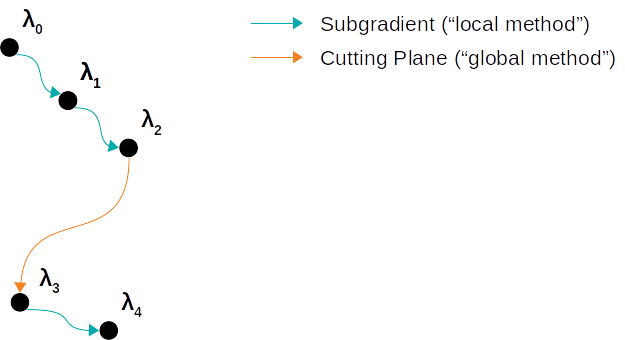

The combination of "local" and "global" methods results in a more effective algorithm than either alone as it provides a good balance between "exploitation" and "exploration", yielding a diverse and comprehensive selection of solutions and, thus, faster convergence and higher-quality final solutions.

### Notation
Consider a generic problem $P$
$$\begin{align*}
\min_{\var{x} \in {X}} & c^\top \var{x} \\
& A^\top \var{x} \ge b ~(*)
\end{align*}$$

Then use the lagrangian relaxation to remove constraints (\*), yielding the relaxed problem $\tilde{P}(\lambda)$ for given multipliers $\lambda$:
$$\min_{\var{x}\in X} \mathcal{L}(\var{x}, \lambda) = c^\top \var{x} + {\lambda}^\top(b-A^\top \var{x})$$

The lagrangian dual $D$ of $P$ is then:
$$\max_{\mult{\lambda}\ge 0} \mathcal{D}(\mult{\lambda}) = \min_{\var{x}\in X}  \mathcal{L} (\mult{\lambda},\var{x})% = c^\top \var{x} + \mult{\lambda}^\top(b-A^\top \var{x})$$

In general, $\mathcal{D}$ is convex but piece-wise (linear), therefore non-smooth, that is the gradient is not defined everywhere, i.e. on the knots of $\mathcal{D}$.

These knots correspond to values of multipliers that make $\mathcal{P}_D$ change orientation abruptly, thus possibly changing its minimum. For example, the partial derivative at a multiplier's value $\lambdaj=\lambda*_j$ that makes its constraint $a_j^\top x \ge b$ satified yields two opposing slopes, with respect to the inner problem $P_D$: a worsening one when increasing the multiplier, which over-penalize the already satisfied constraint, and an improving one when decreasing it, which makes violating the constraint more profitable.

Given multipliers $\lambda$ let the corresponding primal solution be any $x_\lambda = \mathcal{X}(\lambda)\in X$ such that $x_\lambda=\arg\min_{\var{x} \in X} \mathcal{L} (\mult{\lambda},\var{x})$.

***Example of non-smooth $\mathcal{D}$***

Consider
$$\begin{align*}
\max ~& \var{x}\\
 & \var{x} \le 0.25\\
 & 0 \le \var{x} \le 1
\end{align*}
$$
and its dual

$$
\min_{\mult{\lambda}\ge 0} \mathcal{D}(\mult{\lambda}) = \max_{0\le\var{x}\le 1}   \var{x} - \mult{\lambda} (\var{x}-0.25)
$$

The gradient of $\mathcal{D}$ is given by $\frac{\partial}{\partial \lambda}\mathcal{D} ({\lambda})$ $ = -(x_\lambda - 0.25) $.

For $\lambda=1$ the gradient is not defined:
$$\frac{\partial}{\partial \lambda}\mathcal{D} (1) = \begin{cases}
-0.75 \; (x_\lambda = 1) & \lambda \rightarrow 1^-\\ 
\phantom{-}0.25 \; (x_\lambda = 0) & \lambda \rightarrow 1^+
\end{cases}$$

hence it is not defined.


### Subgradients
To determine descent directions for non-smooth functions, we use a subgradient defined as any vector $g_\mathcal{D}(\lambda) : \mathcal{D}(\lambda + d) - \mathcal{D}(\lambda) \ge g_\mathcal{D}(\lambda)^\top d$. 


For $\mathcal{D}$ a subgradient is conveniently given as $g^\Lambda_\mathcal{D}(\lambda)= g^X_\mathcal{D}(x_\lambda)=(b-A^\top x_\lambda)$ with $x_\lambda = \mathcal{X}(\lambda)$. 
Notice that, as the subgradient does not depend on $\lambda$'s actual value, one can compute a valid subgradient for $\mathcal{D}$ given any primal solution $x\in X$.

**Interpretation:** the subgradient direction pushes towards increasing a multiplier $\lambda$ if the corresponding constraint is violated $(b-A^\top x_\lambda)>0$, or decreasing it if the constraint is satisfied $(b-A^\top x_\lambda)<0$.

Compared to gradients, subgradients tend to either under or over estimate the changes of the function in either direction from the current solution, thus they provide slower convergence and more "unstable"/zig-zagging behaviour following descent measures.

For the lat

### Cutting Plane

The Cutting Plane Model (CPM) is defined as:

$$\begin{align*}
\max~& \mult{z} &\\
 & \mult{z} \le c^\top x_{k} + \mult{\lambda}^\top (b-A^\top x_{k})  & \forall k\in K\\
 & \mult{\lambda} \ge 0
\end{align*}$$

The idea is to use any primal solution $x\in X$ to construct a "cut", a linear (lower) approximation $\phi_x(\mult{\lambda})=c^\top x + \mult{\lambda}^\top (b-A^\top x)$ of the function $\mathcal{D}$.<br>
The linear approximation is given by the tuple $(c^\top x,  b-A^\top x)$, called a _bundle_, which are, respectively, the original objective of P evaluated in $x$ and its subgradient.

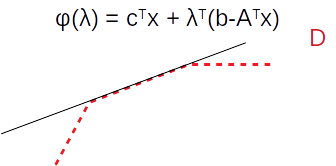

Primal solutions $x$ can come from evaluating $\mathcal{D}$ over a multiplier, i.e. $x=\mathcal{X}(\lambda)$ for some multiplier $\lambda$, or any other method that can deliver a solution $x\in X$, even the primal heuristic.


In this sense, the CPM is also a "learning" algorithm as it can "learn" further pieces of $\mathcal{D}$ iteratively as it explores the dual space of multipliers $\lambda$.

The optimal value of CPM $z$ provides an upper (for max. problems) bound on the value of the dual bound $B^D$, also called a master bound $B^M$.
$B^M$ and $B^D$ converge to the same optimal value, hence we can define a CP optimality gap

$$\textrm{gap}^\textrm{CP}_n= 100 \frac{B^M_n - B^D_n}{B^M_n}$$

As with the optimality gap, we can stop the Primal/Dual loop when the CP gap falls below a given threshdold, which means the CP method has reached converges.

### Subgradient descent


Let $n=0$, $\lambda_0$ be the initial multiplires and  $\mathcal{D}(\lambda_0)$ and $g_0 = g^\Lambda_\mathcal{D}(\lambda_0)$ its dual value and the subgradient. Let the previous direction $d'_0=0$, and the deflection coefficient $\alpha_0=1$. 

Then compute:
1. new directon $d_n = \alpha_n  g_n + (1-\alpha_n) d'_n$
2. new step size $\sigma_n = S(\lambda_0, \mathcal{D}(\lambda_n), d_n, \alpha_n)$
3. new solution $\lambda_{n+1} = \lambda_n + \sigma_n d_n$
4. evaluate the new multipliers, yileding $\mathcal{D}(\lambda_{n+1})$ and $g_{n+1}=g^\Lambda_{\mathcal{D}}(\lambda_{n+1})$
5. let $d'_{n+1}=d_n$; compute new deflection coefficient $\alpha_{n+1) = \delta(d'_{n+1}, g_{n+1})

Possible stopping criterion are number of iterations, magnitude of the subgradient, which, however, could be 

## Algorithm


Consider a generic problem P
$$\begin{align*}
\min_{\var{x} \in {X}} & c^\top \var{x}\\
& A^\top \var{x} \ge b
\end{align*}$$

And its lagrangian dual D
$$\max_{\mult{\lambda}} \mathcal{L}(\mult{\lambda}) = \min_{\var{x}\in X}  c^\top \var{x} + \mult{\lambda}^\top(b-A^\top \var{x})$$
where $\lambda$ are the lagrangian multipliers.

Let P~ be the inner problem in 

Given multipliers $\lambda$ we can then solve D, which yields:
* the value of the lagrangian dual $\mathcal{L}({\lambda})$, which provides a dual/lower bound on the optimal value of $P$ 
* the primal solution for the inner problem $x_\lambda=\mathcal{X}({\lambda}) \in \arg \min_{\var{x}\in X}  c^\top \var{x} + {\lambda}^\top(b-A^\top \var{x})$
* the subgradient $s(x_\lambda) = b-A^\top x_{\lambda}$

0. Let $n=0$. Initialize multipliers $\lambda_n=0$. Usually this is not a good initialization. Often an initial "simple" heuristic for the original problem is used.<br>
   Let global lower bound be $\hat{B^D}=-\infty$, $\hat{B^P}=+\infty$.<br>
1. evaluate the lagrangian dual D yielding a dual bound $B^D_n=\mathcal{L}(\lambda_n)$  a primal solution $x_n = \mathcal{X}(\lambda_n)$  and subgradient $s_n=s(x_n)$. <br>
   if $s_n\le 0$ then $x_n$ is feasible for P and we have a new primal bound $B^{P,\textrm{relax}}_n= c^\top x_n$, otherwise we set $B^{P,\textrm{relax}}_n=+\infty$.   
2. add the cut $z \le c^\top x_n + \mult{\lambda}^\top s_n$ to the Cutting Plane model
3. if $k_h$ iterations have passed since the last primal heuristic run, run the primal heuristic again, yielding a new primal heuristic solution $x^h_n$ and a new primal bound $B^{P, \textrm{heur}}_n= c^\top x^h_n$.<br>
   Add the cut $z \le c^\top x^h_n + \mult{\lambda}^\top s(x^h_n)$ to the Cutting Plane model
4. Update the global bounds $\hat{B}^D = \max(\hat{B}^D, B^D_n)$, $\hat{B}^P = \min(\hat{B}^P, B^{P, \textrm{heur}}_n, B^{P, \textrm{relax}}_n)$<br>
   Compute optimality gap $g_n = 1 - \frac{\hat{B}^D}{\hat{B}^P}$.
5. $n:=n+1$. If $g<\epsilon$ or $n>\bar{n}$ stop, otherwise go to 6
6. compute new multipliers $\lambda_n$, then go to #1.


## Computing multipliers


## Setup

In [9]:
relaxation = ProductionStateRelaxation(data)

var_lb, var_ub = tuple(
    series_dict_to_array(**m)
    for m in relaxation.multipliers_range()
)

## Subgradient
### Target tracking for the subgradient

Target tracking means over-estimating the optimal value of the Lagrangian Function (LF), as we are maximizing it, to determine the step-size for the subgradient algorithm.

We adopt the following policy:
* We get an upper bound of the optimal value from the current Primal Solution (PS), via the `bounds_tracker`, which tracks the best bounds for the whole algorithm.
* If the current PS value is close to the current LF value then our multipliers are good, the current PS value provides a good target and we need to make smaller steps.
   * We assume that if the two values differ less than 20%, they're close.
   * if the PS has not been computed yet, its value is set to +infinity, thus ignored
* Otherwise we take the maximum between:
    * the `fixed_tracker` value, which is the best LF value seen so far (best dual bound) over-estimated by 25%.
    * the `lower_cost_estimate`, which is the minimum possible cost of energy
    
  the rationale is that at the beginning the best LF value can be very low, even lower than  the `lower_cost_estimate`. The latter can thus provide a better upper bound estimate and thus larger step-sizes.

In [10]:
upper_bound = np.nan

lower_cost_estimate = data.loads["value"].sum() * data.thermal_plants["l_cost"].min()

fixed_tracker = FixedTargetTracker(sense=-relaxation.sense, overestimation_factor=0.25)

bounds_tracker = BoundsTracker(sense=relaxation.sense)

def target_tracker(current_lf_value: float) -> float:
    upper_bound = bounds_tracker.best_primal_solution.objective
    if abs(upper_bound - current_lf_value) / abs(current_lf_value + 1e-3) > 0.2:
        fixed_target = fixed_tracker(current_lf_value)
        result = max(fixed_target, lower_cost_estimate)
    else:
        result = upper_bound
    return result

In [11]:
sgd_algorithm_conf  = dict(
            sense=-relaxation.sense,
            var_lb=var_lb,
            var_ub=var_ub,
            step_size_fun=PolyakStepSizeRule(-relaxation.sense, target_tracker),
            deflection_fun=make_CFMDeflection(),
        )

## Cutting Plane

In [12]:
cp_algorithm_config = dict(sense=-relaxation.sense, var_lb=var_lb, var_ub=var_ub)

## Primal Heuristic

The primal heuristic takes a list of primal solutions computed by the combined algorithm and extracts plants' commitments from each.

It then uses the commitments to compute a primal solution for the original problem with the following steps:

1) Combination: uses an LP to compute the optimal _fractional_ combination of the commitments and then select for each plant the (first) commitment with highest fractional value.

2) Local-search: uses the original MIP model and the combined solution at #1 to perform local search. It fixes the plants' state to the value in the combined solution, except the periods with highest energy cost (estimated via LP optimization as lagrangian multipliers) and then solves the residual MIP.

In [13]:
def run_heuristic(primal_solutions):
    solver_options = ["ratio", "0.05", "sec", "40", "doh", "node depth"]
    commitments = [ps["s"] for ps in primal_solutions]
    solution = combinatorial_heuristic(
        data,
        commitments,
        combination_options=dict(
            mip=0, options=solver_options
        ),
    )
    solution = local_search(data, solution, options=solver_options)
    print(
        f" => Heuristic:\tTotal cost: {solution['total_production_cost']:15.5g}\t"
        + f"Demand mismatch cost:{solution['demand_mismatch_cost']:15.5g}"
    )
    return relaxation.information_from_primal_solution(solution)

## Initialization

In [14]:
configuration = AlgorithmConfiguration(
    primal_feasibility_tolerance=1e-4,
    subgradient_tolerance=1e-6,
    sgd_iterations=4,
    cp_iterations=1,
    heuristic_frequency=6,
    max_gap=0.025,
    max_cp_gap=0.01,
    relaxation_solver_options={},
    cp_solver_options={"options": ["seconds 60"]},
    max_iterations=24,
    sgd_name="Polyak+CFM",
    cp_name="CPM",
)

In [15]:
initial_multipliers = relaxation.fill_multipliers(0.0)

bounds_tracker.reset()
fixed_tracker.reset()

combined_algorithm = CombinedAlgorithm(
    configuration,
    relaxation,
    initial_multipliers,
    cp_algorithm_config,
    sgd_algorithm_conf,
    run_heuristic,
    bounds_tracker=bounds_tracker,
)

## Execution

In [16]:
kpi_collector = KpiCollector()
print(pretty_printer.header() + f"|{'Gap% from Optimum*':>25}")
stop = False
while not stop:
    stop = combined_algorithm()
    kpi_collector.collect(combined_algorithm)
    print(
        pretty_printer.row(kpi_collector)
        + f"|{abs(1- (bounds_tracker.best_primal_solution.objective/optimal_value)):>25.2%}"
    )
    
print("\n* Note: the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.")

| It.|    Dual Algorithm|   Current Dual|    Current Master|      Best Dual|    Best Primal|       Best Master|Optimality Gap%|        CP Gap%|       Gap% from Optimum*
|   0|              None|     1.1202e+05|               inf|     1.1202e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   1|        Polyak+CFM|     1.2217e+05|               inf|     1.2217e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   2|        Polyak+CFM|     1.3052e+05|               inf|     1.3052e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   3|        Polyak+CFM|     1.3111e+05|               inf|     1.3111e+05|            inf|               inf|        100.00%|        100.00%|                     inf%
|   4|        Polyak+CFM|     1.3133e+05|               inf|     1.3133e+05|            inf|               inf|        100.00%|        100.00%|            

Local Search => Current cost: 1.5e+05. Demand mismatch cost:4.7e+03
Local Search => New cost: 1.4e+05.New demand mismatch cost:   96. Improvement: 4.02%


 => Heuristic:	Total cost:        1.42e+05	Demand mismatch cost:         96.156
|   6|        Polyak+CFM|    -6.9171e+05|        8.9048e+05|     1.3133e+05|       1.42e+05|        8.9048e+05|          7.52%|         85.25%|                    1.99%
|   7|        Polyak+CFM|    -4.1316e+05|        8.9048e+05|     1.3133e+05|       1.42e+05|        8.9048e+05|          7.52%|         85.25%|                    1.99%
|   8|        Polyak+CFM|     -2.568e+05|        8.9048e+05|     1.3133e+05|       1.42e+05|        8.9048e+05|          7.52%|         85.25%|                    1.99%
|   9|        Polyak+CFM|     -1.749e+05|        8.9048e+05|     1.3133e+05|       1.42e+05|        8.9048e+05|          7.52%|         85.25%|                    1.99%
|  10|               CPM|    -1.2609e+06|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  11|        Polyak+CFM|    -7.6908e+05|          1.42e+05|     1.3133e+05

Local Search => Current cost: 2.3e+05. Demand mismatch cost:1.1e+05
Local Search => New cost: 1.9e+05.New demand mismatch cost:5.9e+04. Improvement: 17.40%


 => Heuristic:	Total cost:      1.9145e+05	Demand mismatch cost:          59316
|  12|        Polyak+CFM|    -5.0381e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  13|        Polyak+CFM|    -2.9195e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  14|        Polyak+CFM|    -1.9255e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  15|               CPM|    -4.9815e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  16|        Polyak+CFM|    -4.4761e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  17|        Polyak+CFM|    -3.7146e+05|          1.42e+05|     1.3133e+05

Local Search => Current cost: 2.5e+05. Demand mismatch cost:1.3e+05
Local Search => New cost: 1.9e+05.New demand mismatch cost:6.4e+04. Improvement: 23.63%


 => Heuristic:	Total cost:      1.9365e+05	Demand mismatch cost:          63766
|  18|        Polyak+CFM|    -2.0755e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  19|        Polyak+CFM|    -1.6262e+05|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  20|               CPM|          35001|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  21|        Polyak+CFM|          39996|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  22|        Polyak+CFM|          51972|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%
|  23|        Polyak+CFM|          54012|          1.42e+05|     1.3133e+05

Local Search => Current cost: 2.3e+05. Demand mismatch cost:1.1e+05
Local Search => New cost: 1.7e+05.New demand mismatch cost:3.5e+04. Improvement: 27.11%


 => Heuristic:	Total cost:      1.6961e+05	Demand mismatch cost:          35314
|  24|        Polyak+CFM|          61661|          1.42e+05|     1.3133e+05|       1.42e+05|          1.42e+05|          7.52%|          7.52%|                    1.99%

* Note: the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.


## Output

### Optimality KPIs

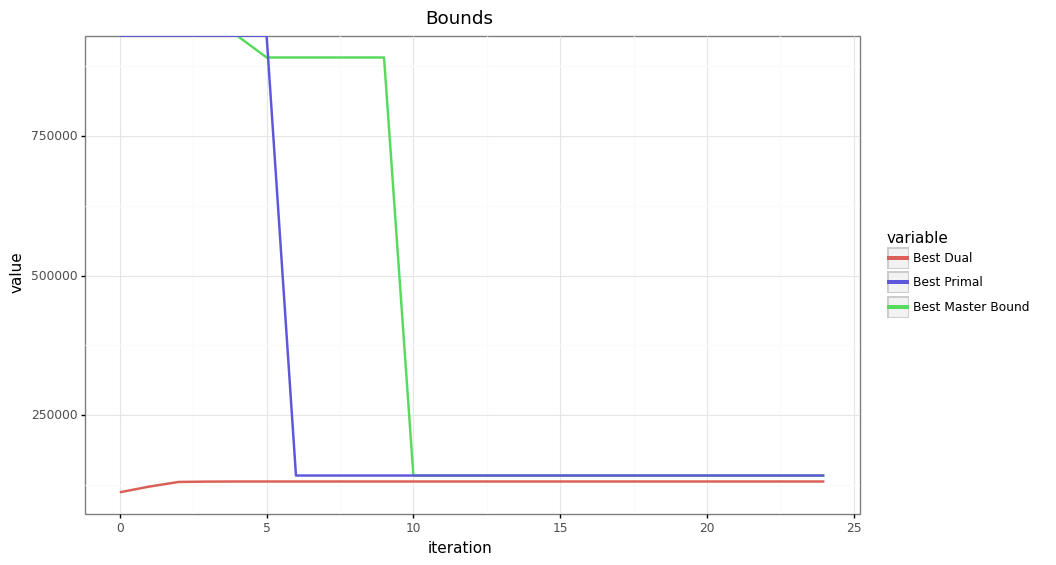

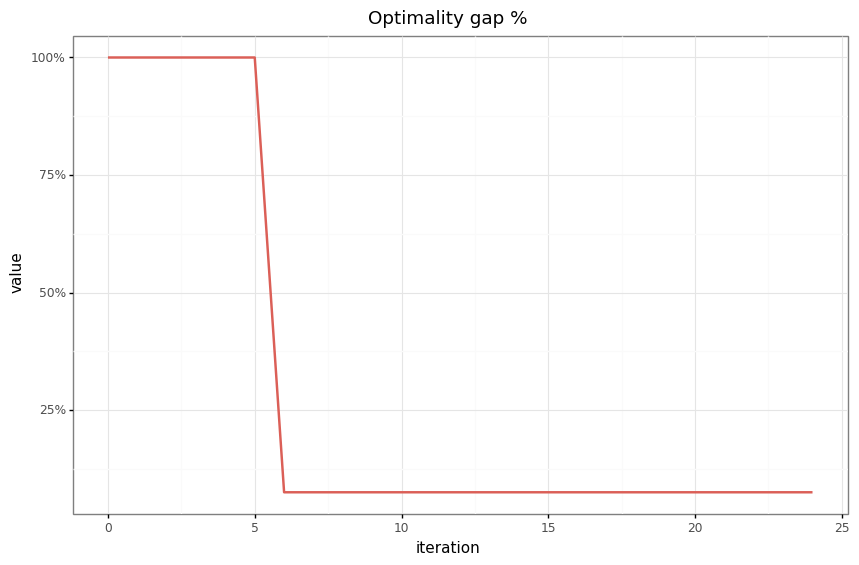

In [17]:
kpis = extract_kpis(kpi_collector.table())
print(algo_charts.bounds(kpis))
print(algo_charts.gap(kpis))

### Solution

In [18]:
solution = bounds_tracker.best_primal_solution.solution

In [19]:
feasible, analysis = ck.check_solution(data, solution)
assert feasible, "ERROR: final solution is infeasible."

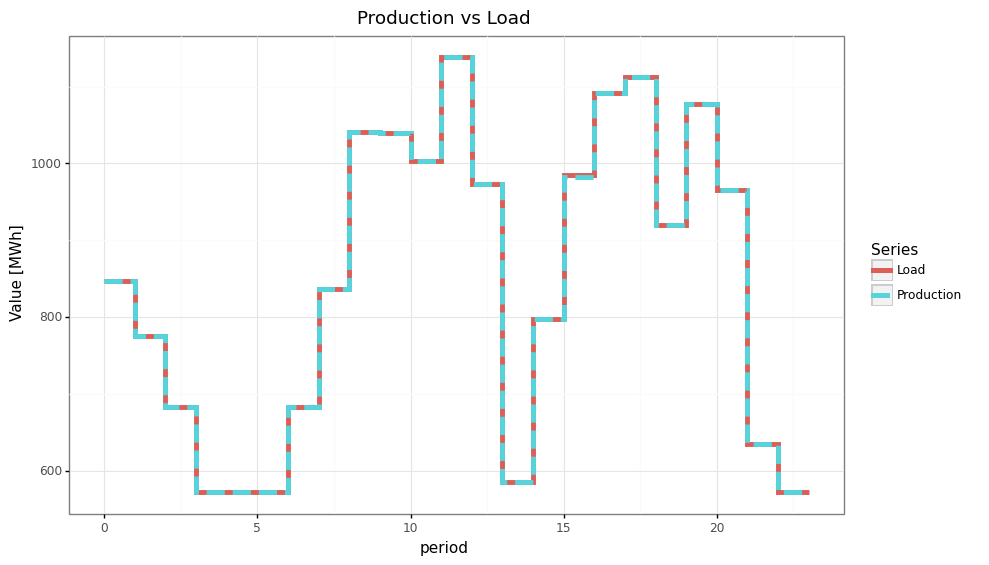

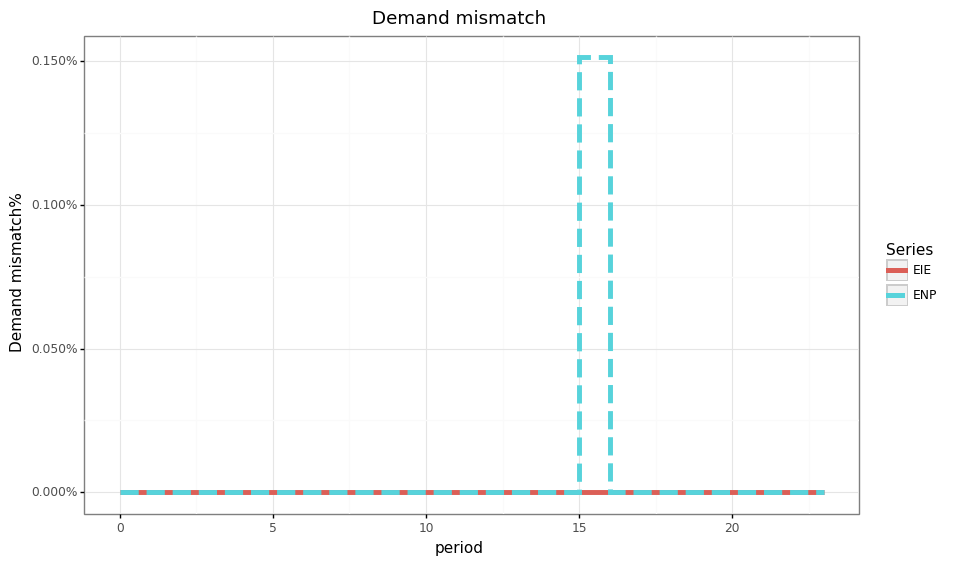

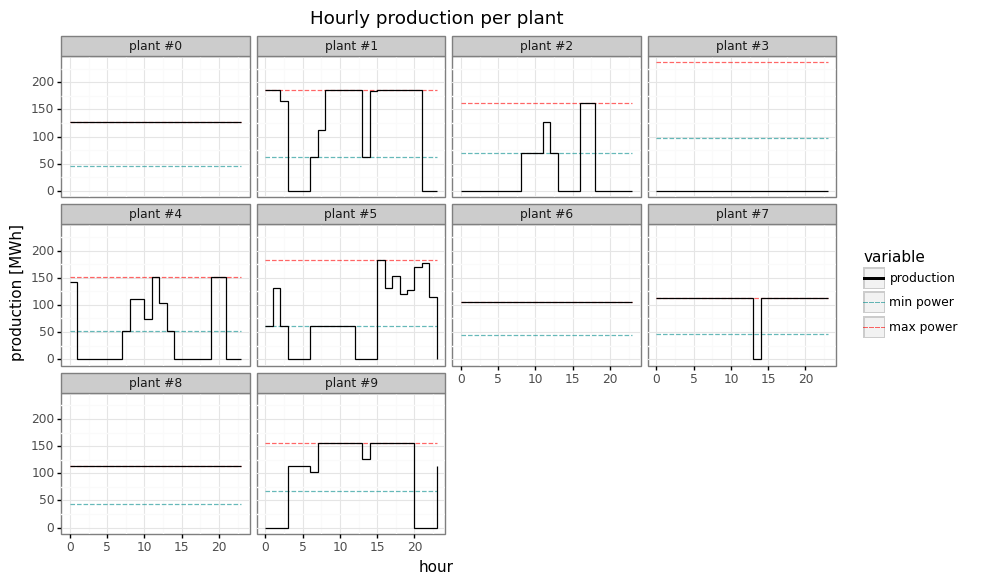

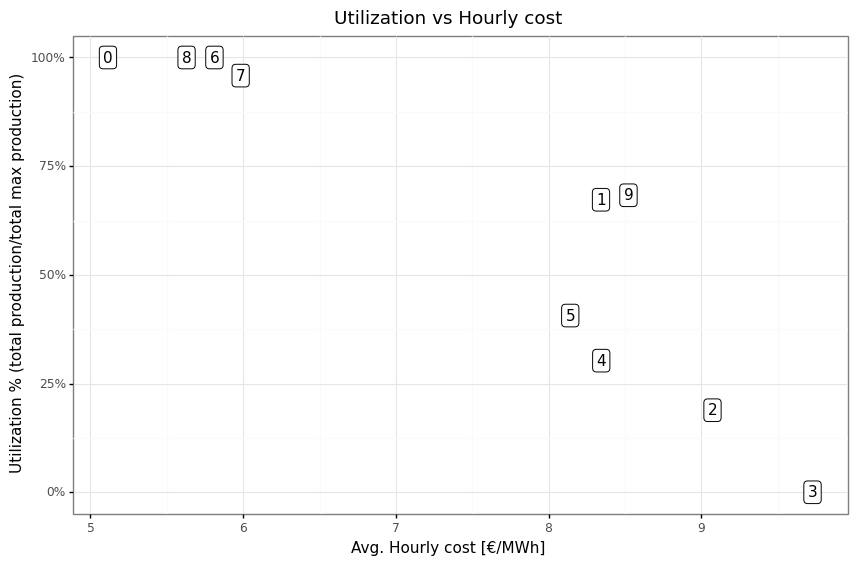

In [20]:
plots = [
    charts.total_production(data, solution),
    charts.enp_vs_eie(data, solution),
    charts.production_by_plant(data, solution),
    charts.plant_utilization(data, solution),
]

for p in plots:
    print(p)